## Imports

In [1]:
from ipynb.fs.full.Jacobian import *

import numpy as np
from numpy import linalg as LA
import sympy as sp

import matplotlib.pyplot as plt
import math

## Global Variables

In [16]:
#Time variables
interval = 10
delta = 0.1

#Numbers represent how far we want to be precised.
Epsilon = 10**-2
Nnewton = 10

## Transitionals functions
### Solver with one equation

In [17]:
"""
    Create the function f wich correspond to this equality : du/dt = expr(u, v). 
    Here du/dt -> un - un-1 / delta
    
    @return: the new function ready to be evaluated.
    
    @var: the symbol we want to evalute (u or v)
    @term_1: the previous term
    @expr: the function tied.
"""

def create_f(var, term_1, expr):
    return (var - term_1)/delta - expr

In [18]:
"""
    Create a list like that : [[t0, u0], [t1, u1], ..., [tn, un]]

    @return: [[t0, u0], [t1, u1], ..., [tn, un]]
    
    @time: [t0, t1, ...]
    @function: [u0, u1, ...]
"""

def result_one_eq(time, function):
    final_points = []
    for i in range(len(function)):
        final_points.append([time[i], function[i]])
        
    return final_points

### Solver with 2 equations

In [19]:
"""
    Same as create_f. The only difference is that this time we 
    keep it in a vector cause we have two different functions.
    
    @return: a vector containing the 2 new functions ready to be evaluated.
    
    @uk_1: u previous term
    @vk_1: v previous term
    @f1: first function
    @f2 second function
"""

def create_2_f(uk_1, vk_1, f1, f2):
    return np.array([create_f(u, uk_1, f1), create_f(v, vk_1, f2)])

In [20]:
"""
    Create the 2x2 matrix wich correspond to the derivate of F(xk) 
    when xk is vector like xk = (f1, f2).
    This matrix = [df1/du , df2/du]
                  [df1/dv , df2/dv]
    
    @return: new matrix created.
    
    @x1: second variable
    @x2: first variable
    @f1: first function
    @f2: second function
"""

def f_prime_2_eqs(x1, x2, f1, f2):
    res = np.array([[0, 0], [0, 0]])
    symbols = [u, v]
    tab_x = [x1, x2]
    tab_f = [f1, f2]
    
    for i in range(2):
        for j in range(2):
            res[i][j] = Jacobian_square_mat(symbols[i], tab_f[j]).subs(symbols[i], tab_x[j])
    
    return res

In [21]:
"""
    Create the term F(xk_1) wich is a vector of size 2 containing the evaluation
    respectivly of f1 and f2.
    
    @return: the term F(xk_1)
    
    @uk_1: u previous term
    @vk_1: v previous term
    @fu: first expression in the inital system.
    @fv: second expr in the initial system.
    @vec_f: list containing f1 and f2
    @i: index to recup the correct previous term of the function.
"""

def create_fxk_1(uk_1, vk_1, fu, fv, vec_f, i):
    res = np.array([0, 0])
    if(i == 0):
        for j in range(2):
            res[j] = vec_f[j].subs([u, uk_1], [v, vk_1])
    else:
        for j in range(2):
            res[j] = vec_f[j].evalf(subs={u: fu[i-1], v: fv[i-1]})
    
    return res

In [22]:
"""
    Create a list containings the lists of points to build the u function
    and the v function.
    [ [ [t0, u0], [t1, u1], ..., [tn, un] ] , [ [t0, v0], [t1, v1], ..., [tn, vn] ] ]
    
    @time: list containing t0, t1, t2, ...
    @fu: list containing u0, u1, u2, ...
    @fv: list containing v0, v1, v2, ...
"""

def result_2_eq(time, fu, fv):
    #Creation of our final list containing tuples like that: (time, function)
    final_points_u = []
    final_points_v = []
    
    for i in range(len(fu)):
        final_points_u.append([time[i], fu[i]])
        final_points_v.append([time[i], fv[i]])
        
    return [final_points_u, final_points_v]

## Solver for one differencial equation

In [26]:
def Solver_one_equation(expr, u0):
    t0 = 0
    i = 1
    f_uk = 1
    uk_1 = u0
    nb = 0
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Function = [u0, u1, u2, ...., un]
    function = [u0]
    time = [t0]
    
    first = True
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        
        #Newton's method
        while(f_uk > Epsilon or nb < Nnewton):
            nb+=1
            f_uk_1 = 0
            f_uk_1_prime = 0
            
            # First step, we change our equation to f(x) = 0
            f = create_f(u, uk_1, expr)
            
            # We recup the term f(uk-1)
            if(first):
                f_uk_1 = f.subs(u, uk_1)
                first = False
            
            else:
                f_uk_1 = f.subs(u, function[i-1])
            
            #We recup the term f'(uk_1)
            f_uk_1_prime = Jacobian_one(f).subs(u, uk_1)

            #Formula : uk = uk_1 - (f(uk_1) / f'(uk_1))
            uk = uk_1 - (f_uk_1 / f_uk_1_prime)
            

            #Check the approximation. If f_uk < Epsilon = good approximation
            f_uk = f.subs(u, uk)
            uk_1 = uk
            if(f_uk < Epsilon):
                break
        
        #Update our 2 lists and indexes.
        time.append(t0)
        function.append(uk)
        f_uk = 1
        i += 1
        nb = 0

        return result_one_eq(time, function)

## Solver for 2 differentials equations

In [24]:
def Solver_two_equations(u0, v0, f1, f2):
    t0 = 0
    i = 1
    f_xk = 1
    uk_1 = u0
    vk_1 = v0
    xk_1 = np.array([uk_1, vk_1])
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Functions = [u0, u1, u2, ...., un]
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        print(t0)
        #Newton's method
        while(nb < Nnewton):
            nb+=1
            
            # First step, we change our equation to F(x) = 0
            vec_f = create_2_f(uk_1, vk_1, f1, f2)
            
            #Creating F(xk-1)
            F_xk_1 = create_fxk_1(uk_1, vk_1, fu, fv, vec_f, i)
            
            #Creating F'(xk-1)
            F_xk_1_prime = f_prime_2_eqs(uk_1, vk_1, vec_f[0], vec_f[1])
            #print("vec_f = ", end='')
            #print(vec_f)
            #print("fxk_1 = ", end='')
            #print(F_xk_1)
            #print("f'xk_1 = ", end='')
            #print(LA.inv(F_xk_1_prime))
            #print(np.dot(F_xk_1, LA.inv(F_xk_1_prime)))
            
            #Formula : xk = xk_1 - tr(F'(xk_1)) * F(xk_1)
            xk = xk_1 - np.dot(LA.inv(F_xk_1_prime), F_xk_1)
            #print("xk = ", end='')
            print(xk)
            
            #Check the approximation. If f_uk < Epsilon = good approximation
            f_xk = LA.norm(xk - xk_1)
            #print("f_xk = ", end='')
            #print(f_xk)
            #print("nb = ", end='')
            #print(nb)
            
            if(f_xk < Epsilon):
                break
            
            xk_1 = xk
        
        #Update our 2 lists and indexes.
        time.append(t0)
        fu.append(xk[0])
        fv.append(xk[1])
        uk_1 = xk[0]
        vk_1 = xk[1]
        f_xk = 1
        i += 1
      
    return result_2_eq(time, fu, fv)

## Unitary tests
### Tests with only one equation.
### exp(-x)

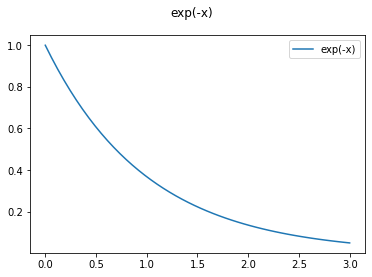

[[0, 1], [0.1, 0.909090909090909]]


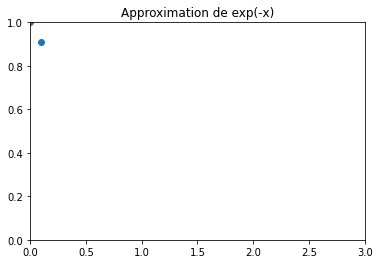

In [27]:
fig, ax = plt.subplots()
x = np.linspace(0, 3, 50)
y = np.exp(-x)
ax.plot(x, y, label ='exp(-x)')
plt.legend()  
plt.suptitle('exp(-x)')
plt.show()

res = Solver_one_equation(-u, 1)
print(res)

absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])
    
plt.ylim([0, 1])
plt.title('Approximation de exp(-x)')
plt.xlim([0, 3])
plt.scatter(absi, coords)

### exp(x)

## Tests with 2 equations


0.1
[0.80991736 1.90909091]
[0.61983471 1.81818182]
[0.42975207 1.72727273]
[0.23966942 1.63636364]
[0.04958678 1.54545455]
[-0.14049587  1.45454545]
[-0.33057851  1.36363636]
[-0.52066116  1.27272727]
[-0.7107438   1.18181818]
[-0.90082645  1.09090909]
0.2
[-0.90909091  1.        ]
[-0.91735537  0.90909091]
[-0.92561983  0.81818182]
[-0.9338843   0.72727273]
[-0.94214876  0.63636364]
[-0.95041322  0.54545455]
[-0.95867769  0.45454545]
[-0.96694215  0.36363636]
[-0.97520661  0.27272727]
[-0.98347107  0.18181818]
0.30000000000000004
[-0.99173554  0.09090909]
[-1.00000000e+00  6.38378239e-16]
[-1.00826446 -0.09090909]
[-1.01652893 -0.18181818]
[-1.02479339 -0.27272727]
[-1.03305785 -0.36363636]
[-1.04132231 -0.45454545]
[-1.04958678 -0.54545455]
[-1.05785124 -0.63636364]
[-1.0661157  -0.72727273]
0.4
[-0.97520661 -0.72727273]
[-0.88429752 -0.72727273]
[-0.79338843 -0.72727273]
[-0.70247934 -0.72727273]
[-0.61157025 -0.72727273]
[-0.52066116 -0.72727273]
[-0.42975207 -0.72727273]
[-0.3388

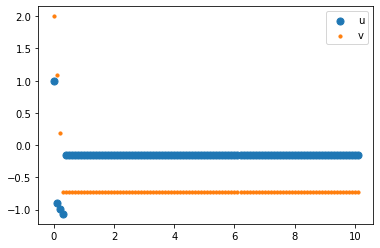

In [13]:
u0 = 1
v0 = 2
a = 2
b = 2
du = (-b/a)*u - (1/a)*v
dv = u - v

res = Solver_two_equations(u0, v0, du, dv)
print(res[0])
print("-------")
print(res[1])

time = []
coords_u = []
coords_v = []

for i in range(0, len(res[0])):
    time.append(res[0][i][0])
    coords_u.append(res[0][i][1])
    coords_v.append(res[1][i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(time, coords_u, s=50, label='u')
ax1.scatter(time, coords_v, s=10, label='v')
plt.legend(loc='upper right');
plt.show()
